In [1]:
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
from torch.utils.data import Dataset, dataloader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import torch.onnx
from model_wrapper import Landing_Club_Wrapper
import matplotlib.pyplot as plt
import pickle as p

pd.options.display.max_rows=999

In [2]:
FULL_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4.csv'
SMALL_SAMPLE_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_sample.csv'
SMALL_HEAD_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_head.csv'

Sample a few records for faster work

In [3]:
# Make small dataset
# col_names = ['loan_amnt', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'term', 'emp_length', 'int_rate']
# col_names = ['loan_amnt', 'home_ownership', 'annual_inc','term', 'emp_length', 'int_rate']
COL_NAMES = ['loan_amnt', 'home_ownership', 'annual_inc', 'int_rate']
FEATURE_NAMES = ['loan_amnt', 'home_ownership', 'annual_inc']
LABEL_NAME = 'int_rate'
record_count = 1000
# acc_raw_df = pd.read_csv(FULL_DATASET_NAME)
# acc_raw_df.sample(record_count).to_csv(SMALL_SAMPLE_DATASET_NAME, columns=col_names)
# acc_raw_df.head(record_count).to_csv(SMALL_HEAD_DATASET_NAME, columns=col_names)

Read the small dataset

In [4]:

class Landing_Club_Dataset(Dataset):
    def __init__(self, file_path: str, col_label, col_names = []):
        self.sc_x = StandardScaler()
        self.sc_y = StandardScaler()
        self.label_enc = LabelEncoder()
        self.file_path = file_path
        self.col_label = col_label
        
        self.df = pd.read_csv(file_path, usecols = col_names)
        self.df.describe()
        self.np = self.to_numpy()
        self.clean()
        self._split_X_y() # split feature columns and label column
        self.encode_categorical_columns()
        self._split_train_test_and_standardize(test_size=.2)
        self.to_tensor()
    
    def __get_item__(self, index: int):
        return (self.X_tsor[index], self.y_tsor[index])
    
    def __len__(self):
        return len(self.df)
    
    def to_numpy(self):
        return self.df.to_numpy()
    
    def to_tensor(self, with_grad=False):
        # return torch.from_numpy(self.np.astype(np.float32))
        self.X_tsor = torch.tensor(DataFrame.to_numpy(self.X_df), requires_grad=with_grad)
        self.y_tsor = torch.tensor(self.y_df, requires_grad=with_grad)
    
    def clean(self):
        self.df.dropna(inplace=True)
        # self.np = self.to_numpy()
        return
    
    def encode_categorical_columns(self):
        categorical_cols = list(self.X_df.select_dtypes(include=['object']))
        print(f'Categorical columns: {categorical_cols}')
        print(f'X_df = {self.X_df.to_numpy()[0]}')
        for col in categorical_cols:
            label_encoded = self.label_enc.fit_transform(self.X_df[col])
            self.X_df[col] = label_encoded
        print(f'X_df = {self.X_df.to_numpy()[0]}')

    def _split_X_y(self):
        self.X_df = self.df.drop(columns=[self.col_label])
        self.y_df = self.df[self.col_label]

    def _split_train_test_and_standardize(self, test_size):
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(self.X_df.values, self.y_df.values, test_size=test_size)

        y_train_orig = y_train_orig.reshape(-1, 1)
        y_test_orig = y_test_orig.reshape(-1, 1)

        self.X_train = Landing_Club_Wrapper.standardize(self.sc_x, X_train_orig, True)
        self.X_test = Landing_Club_Wrapper.standardize(self.sc_x, X_test_orig, False)
        self.y_train = Landing_Club_Wrapper.standardize(self.sc_y, y_train_orig, True)
        self.y_test = Landing_Club_Wrapper.standardize(self.sc_y, y_test_orig, False)

    def get_train_dataset(self):
        X_train_tsor = torch.from_numpy(self.X_train.astype(np.float32))
        y_train_tsor = torch.from_numpy(self.y_train.astype(np.float32))
        return (X_train_tsor, y_train_tsor)

    def get_test_dataset(self):
        X_test_tsor = torch.from_numpy(self.X_test.astype(np.float32))
        y_test_tsor = torch.from_numpy(self.y_test.astype(np.float32))
        return (X_test_tsor, y_test_tsor)


    

In [5]:
dataset = Landing_Club_Dataset(SMALL_HEAD_DATASET_NAME, LABEL_NAME, COL_NAMES)
wrapper = Landing_Club_Wrapper(dataset.sc_x, dataset.sc_y, dataset.label_enc)

print(f'scaler x-mean = {dataset.sc_x.mean_}')
print(f'scaler y-mean = {dataset.sc_y.mean_}')
wrapper_file = open('landing_club_wrapper.pickle', 'wb')
p.dump(wrapper, wrapper_file)
wrapper_file.close()

feature_list = [3600.0, 'MORTGAGE', 40000.0]
wrapper.preprocess(feature_list)
# dataset.df.head(3)
# type(dataset.df.int_rate[0])


Categorical columns: ['home_ownership']
X_df = [3600.0 'MORTGAGE' 55000.0]
X_df = [ 3600.     0. 55000.]
scaler x-mean = [1.55093438e+04 7.87500000e-01 8.05107094e+04]
scaler y-mean = [11.9984375]
encoded homeowner = 0
features_list = [3600.0, 0, 40000.0]
Encoded = [ 3600.     0. 40000.]
np_features = [[ 3600.     0. 40000.]]
scaled = [[-1.37928961 -0.86447492 -0.96778147]]


Split features and label

Define Model explicitely as a Class

In [26]:
feature_count = len(dataset.X_df.columns)

class ClassModel(nn.Module):
   def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, 5)
      self.relu1 = nn.ReLU()
      self.fc2 = nn.Linear(5, 5)
      self.relu2 = nn.ReLU()
      self.fc3 = nn.Linear(5, 1)

   def forward(self, X):
      x = self.fc1(X)
      x = self.relu1(x)
      x = self.fc2(x)
      x = self.relu2(x)
      x = self.fc3(x)
      return x
   
class_model = ClassModel(feature_count, 1)
seq_model = nn.Sequential(
   nn.Linear(feature_count, 15),
   nn.Sigmoid(),
   nn.Linear(15, 15),
   nn.Sigmoid(),
   nn.Linear(15, 1)
)

Define training objects

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(lr=.3, params=seq_model.parameters())

Create Tensors

In [28]:
(X_train_tsor, y_train_tsor) = dataset.get_train_dataset()
(X_test_tsor, y_test_tsor) = dataset.get_test_dataset()

print(X_train_tsor[0:9])
print(y_train_tsor[0:9])
# print(f'Encode {y_train_orig[5][0]} = {y_train[5][0]}, Decode = {sc_y.inverse_transform(y_train[5][0].reshape(-1, 1)).reshape(1)[0]}')


tensor([[-0.5272, -0.8676, -0.4737],
        [-0.4133,  1.3219, -1.2042],
        [-0.1855, -0.8676,  1.0733],
        [ 0.4978,  1.3219, -0.4737],
        [ 0.6800, -0.8676,  0.9632],
        [-0.6411,  1.3219, -0.9503],
        [-1.2106, -0.8676,  1.4885],
        [ 1.4090, -0.8676,  0.6040],
        [-1.5067,  1.3219, -0.7132]])
tensor([[-0.9271],
        [-0.2526],
        [ 1.1129],
        [-0.0881],
        [-1.1433],
        [-0.9271],
        [-0.7908],
        [ 0.9202],
        [-1.0258]])


Train Model

In [29]:
losses = []
n_epochs = 20000
seq_model.train()
for n in range(n_epochs):
   # outputs = myModel(X_train_tsor)
   outputs = seq_model(X_train_tsor)
   
   loss = criterion(outputs, y_train_tsor)
   losses.append(loss)
   # print(loss.item())
   if (n % (n_epochs / 10) == 0):
      with torch.no_grad():
         peek_output_element = 3
         print(f'Loss on epoch ' 
               f'{n:04}: {loss.item():.4f} - '
               f'interest rate: '
               f'{dataset.sc_y.inverse_transform(outputs[peek_output_element].reshape(-1,1)).reshape(1).item():.4f}'
               f'/ '
               f'{dataset.sc_y.inverse_transform(y_train_tsor[peek_output_element].reshape(-1, 1)).reshape(1).item():.4f}')
   loss.backward()
   optimizer.step()
   optimizer.zero_grad()


Loss on epoch 0000: 1.5471 - interest rate: 15.0152/ 11.4800
Loss on epoch 2000: 0.9104 - interest rate: 13.0086/ 11.4800
Loss on epoch 4000: 0.8884 - interest rate: 12.9131/ 11.4800
Loss on epoch 6000: 0.8833 - interest rate: 12.7882/ 11.4800
Loss on epoch 8000: 0.8795 - interest rate: 12.8369/ 11.4800
Loss on epoch 10000: 0.8763 - interest rate: 12.8100/ 11.4800
Loss on epoch 12000: 0.8732 - interest rate: 12.6642/ 11.4800
Loss on epoch 14000: 0.8697 - interest rate: 12.4514/ 11.4800
Loss on epoch 16000: 0.8661 - interest rate: 12.3130/ 11.4800
Loss on epoch 18000: 0.8618 - interest rate: 12.3093/ 11.4800


Validate Predictions

Prediction / Test [0] = [[12.71919716]] / [[5.31999975]]
Prediction / Test [1] = [[10.18784039]] / [[7.90999997]]
Prediction / Test [2] = [[13.43760681]] / [[20.49999993]]
Prediction / Test [3] = [[13.39875269]] / [[9.16999999]]
Prediction / Test [4] = [[12.83633343]] / [[24.24000029]]
Prediction / Test [5] = [[13.08372632]] / [[13.44000002]]
Prediction / Test [6] = [[13.23971593]] / [[19.88999976]]
Prediction / Test [7] = [[10.58146746]] / [[19.48000002]]
Prediction / Test [8] = [[9.73503349]] / [[16.58999992]]
Prediction / Test [9] = [[13.97646983]] / [[5.31999975]]


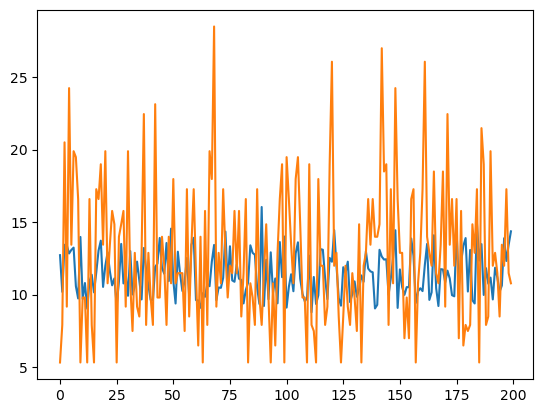

In [30]:
with torch.no_grad():
   seq_model.eval()
   preds = seq_model(X_test_tsor)
   # X_test_feat_0 = X_test[2:, 0:1].reshape(-1)
   preds_decoded = dataset.sc_y.inverse_transform(preds)
   y_test_tsor_decoded = dataset.sc_y.inverse_transform(y_test_tsor)
   for i in range(0, 10):
      print(f'Prediction / Test [{i}] = '
            f'{preds_decoded[i].reshape(-1, 1)} / '
            f'{y_test_tsor_decoded[i].reshape(-1, 1)}')
   plt.cla()
   plt.plot(preds_decoded)
   plt.plot(y_test_tsor_decoded)
   # plt.scatter(X_test_feat_0[0:10], y_test[0:10])
   # plt.scatter(X_test_feat_0[0:10], preds[0:10])
